In [6]:
%pylab inline
#this just allows us to output plots in the .ipynb file, i.e. 'inline'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

Populating the interactive namespace from numpy and matplotlib


In [5]:
from nbodykit.lab import BigFileCatalog
import warnings
warnings.filterwarnings('ignore')
from nbodykit.transform import ConcatenateSources, CartesianToEquatorial

import numpy as np
import healpy as hp
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt

In [6]:
"""cosmology with certain cosmological parameters, in our case, we set h=0.6774, omega0_m=0.3089"""
Om0 = 0.309
H0=67.74
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

In [7]:
def read_range(cat, amin, amax):
    """ Read a portion of the lightcone between two red shift ranges
        The lightcone from FastPM is sorted in Aemit and an index is built.
        So we make use of that.
        CrowCanyon is z > 0; We paste the mirror image to form a full sky.
    """
    edges = cat.attrs['aemitIndex.edges']
    offsets = cat.attrs['aemitIndex.offset']
    start, end = edges.searchsorted([amin, amax])
    if cat.comm.rank == 0:
        cat.logger.info("Range of index is %d to %d" %(( start + 1, end + 1)))
    start = offsets[start + 1]
    end = offsets[end + 1]
    cat =  cat.query_range(start, end)
    if cat.csize > 0:
        cat['RA'], cat['DEC'] = CartesianToEquatorial(cat['Position'], frame='galactic')
    else:
        cat['RA'] = 0
        cat['DEC'] = 0
    return cat

49152
49151
49152


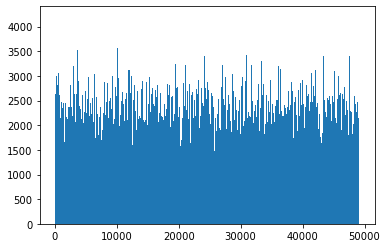

In [8]:
# At NERSC
#basedir = "/global/cfs/cdirs/m3035/yici/rfof_proc262144_nc8192_size5000_nsteps60lin_ldr0_rcvtrue_fstnone_pnf2_lnf2_s100_pgdtrue_dhf1.0000_tiled0.20_fll_elllim_10000_npix_4096/"
# At IPMU
basedir = "/gpfs02/work/tanimura/data/sims/halfdome/"
halodir = basedir + 'usmesh/'

"""This reads the halo map and prepare a healpix map with NPIX=64"""
lightcone1 = BigFileCatalog(halodir,dataset='RFOF') #read the data
lc1 = read_range(lightcone1,0.49,0.51) #Read a portion of the lightcone between two red shift ranges
##the simulations start at a ≡ 1/(1 + z) = 0.1 (z = 9). A total of 60 timesteps were used to evolve the simulations to a = 1 (z = 0). We store  the output boxes at  z = 2, z = 1 and z = 0.
Ra = lc1['RA'].compute() #read the right ascension of lightcone
Dec = lc1['DEC'].compute() #read the declination of lightcone
theta = 0.5 * np.pi - np.deg2rad(Dec) #from declination to theta
phi = np.deg2rad(Ra) #from right ascension to phi
NSIDE = 64 
pix_num = hp.pixelfunc.ang2pix(NSIDE, theta, phi) #obtain the pixel number for a certain {theta,phi}
NPIX = hp.nside2npix(NSIDE) #total pixel number based on NSIDE
print(NPIX)
print(np.max(pix_num))
[num_lc, bins_lc, patches_lc] = plt.hist(pix_num,range=(0,NPIX),bins=NPIX)
print(len(num_lc))

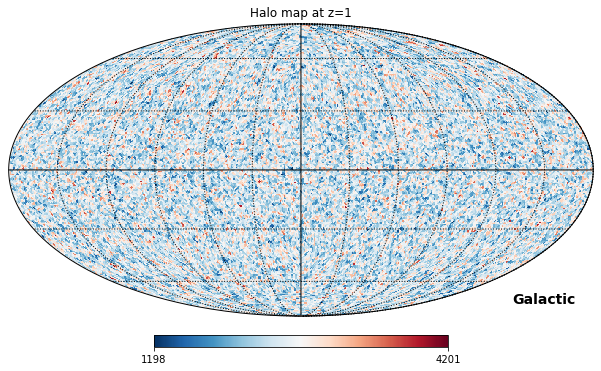

In [12]:
hp.mollview(num_lc,coord='G',title='Halo map at z=1',cmap='RdBu_r')
hp.graticule()

In [15]:
edges = np.array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

Nabin = len(edges)-1
print(Nabin)

100


In [16]:
Nc_list = np.zeros(Nabin)
Mmin_list = np.zeros(Nabin)
Mmax_list = np.zeros(Nabin)

for i in range(Nabin):
    lc_i = read_range(lightcone1,edges[i],edges[i+1])
    Nc_i = lc_i.size
    Nc_list[i] = Nc_i
    print("Nc=%d (%.2f < a < %.2f)" %(Nc_i, edges[i], edges[i+1]))
    
    if(Nc_i != 0):
        lc_i['Mass']=lc_i['Length'] * lc_i.attrs['M0'] * 1e10
        Mass_i = lc_i['Mass'].compute()
        Mmin_list[i] = np.min(Mass_i)
        Mmax_list[i] = np.max(Mass_i)

Nc=0 (0.00 < a < 0.01)
Nc=0 (0.01 < a < 0.02)
Nc=0 (0.02 < a < 0.03)
Nc=0 (0.03 < a < 0.04)
Nc=0 (0.04 < a < 0.05)
Nc=0 (0.05 < a < 0.06)
Nc=0 (0.06 < a < 0.07)
Nc=0 (0.07 < a < 0.08)
Nc=0 (0.08 < a < 0.09)
Nc=0 (0.09 < a < 0.10)
Nc=0 (0.10 < a < 0.11)
Nc=0 (0.11 < a < 0.12)
Nc=0 (0.12 < a < 0.13)
Nc=0 (0.13 < a < 0.14)
Nc=0 (0.14 < a < 0.15)
Nc=0 (0.15 < a < 0.16)
Nc=0 (0.16 < a < 0.17)
Nc=0 (0.17 < a < 0.18)
Nc=0 (0.18 < a < 0.19)
Nc=0 (0.19 < a < 0.20)
Nc=38 (0.20 < a < 0.21)
Nc=126263353 (0.21 < a < 0.22)
Nc=194827459 (0.22 < a < 0.23)
Nc=207209332 (0.23 < a < 0.24)
Nc=212111163 (0.24 < a < 0.25)
Nc=212414511 (0.25 < a < 0.26)
Nc=214862003 (0.26 < a < 0.27)
Nc=212199822 (0.27 < a < 0.28)
Nc=207245623 (0.28 < a < 0.29)
Nc=203518877 (0.29 < a < 0.30)
Nc=196886833 (0.30 < a < 0.31)
Nc=189129507 (0.31 < a < 0.32)
Nc=182311604 (0.32 < a < 0.33)
Nc=174177270 (0.33 < a < 0.34)
Nc=165625101 (0.34 < a < 0.35)
Nc=157683776 (0.35 < a < 0.36)
Nc=149608671 (0.36 < a < 0.37)
Nc=141264676 (0.37 <

In [5]:
#np.savetxt("Nc_list.dat", Nc_list, fmt="%d") 
#np.savetxt("Mmin_list.dat", Mmin_list) 
#np.savetxt("Mmax_list.dat", Mmax_list) 
